# Import thư viện

In [22]:
import re
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from pyvi import ViTokenizer  
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import os 
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set NumPy print options
np.set_printoptions(precision=2, linewidth=80)
import seaborn as sns

In [3]:
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Tiền xử lý dữ liệu

In [4]:
def lay_file_sua_du_lieu(dia_chi_luu_file_sua_chinh_ta):
    loaded_dict_list = []
    file_names = ['sua_viet_tat','sua_chinh_ta','dich_tieng_anh']
    
    for file_name in file_names:
        with open(f'{dia_chi_luu_file_sua_chinh_ta}/{file_name}.json', "r", encoding="utf-8") as file:
            loaded_dict = json.load(file)
            loaded_dict_list.append(loaded_dict) 
               
    return loaded_dict_list

In [5]:
def normalize_acronyms(text, replace_list):
    for k, v in replace_list.items():
        text = text.replace(k, v)
    return text

In [9]:
# Hàm tiền xử lý văn bản
def preprocess_normalize_text(text, dia_chi_luu_file_sua_chinh_ta):
    text = str(text)  # Đảm bảo đầu vào là chuỗi
    text = text.lower()  # Chuyển về chữ thường
    text = re.sub(r"(.)\1{2,}", r"\1", text) # Loại bỏ ký tự kéo dài 2 lần trở lên
    text = re.sub(r"\d+", "", text)  # Xóa số
    text = re.sub(r"[^\w\s\u00C0-\u1FFF\u2C00-\uD7FF]", " ", text) # Loại bỏ các ký tự đặc biệt
    text = ' ' + text + ' '  # Thêm khoảng trắng vào đầu và cuối text
    
    replace_list = lay_file_sua_du_lieu(dia_chi_luu_file_sua_chinh_ta)
    for list in replace_list:
        text = normalize_acronyms(text, list)  # Chuẩn hóa từ viết tắt
    
    return text

In [35]:
def stopword_and_tokenize_text(text, stopwords_path):
    # # Xử lý biểu tượng cảm xúc
    # text = emoji.demojize(text)
    # text = re.sub(r":\w*:", lambda match: "positive" if "smile" in match.group() or "heart" in match.group() else "negative", text)

    # Tách từ 
    text = ViTokenizer.tokenize(text)

    # Loại bỏ stopwords
    if stopwords_path:
        with open(f'{stopwords_path}/vietnamese-stopwords.txt', "r", encoding="utf-8") as f:
            stopwords = set(word.strip() for word in f.readlines())
        text = " ".join(word for word in text.split() if word not in stopwords)

    return text

# Mô hình Bi-LSTM

In [30]:
def tao_mo_hinh(data_path):
    # Hàm để lấy đường dẫn file theo tên
    def get_file_by_name(directory, filename):
        file_path = os.path.join(directory, filename)
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Không tìm thấy file '{filename}' trong thư mục '{directory}'")
        return file_path

    # Đọc cấu trúc mô hình từ file JSON
    json_path = get_file_by_name(data_path, "model_structure.json")
    with open(json_path, "r") as json_file:
        model_json = json_file.read()

    # Tạo mô hình từ cấu trúc JSON
    model = model_from_json(model_json)

    print("Cấu trúc model đã được tải thành công!")

    # Đọc trọng số mô hình từ file pickle
    weights_path = get_file_by_name(data_path, "model_weights.pkl")
    with open(weights_path, "rb") as weights_file:
        model.set_weights(pickle.load(weights_file))
        
    print("Trọng số model đã được tải thành công!")

    # Tải tokenizer từ file
    tokenizer_path = get_file_by_name(data_path, "tokenizer.pkl")
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    print("Tokenizer đã được tải thành công!")
    max_length = 60
    return model, tokenizer, max_length

In [48]:
import numpy as np

def predict_sentiment(model, tokenizer, input_texts, max_length):
    """
    Hàm dự đoán cảm xúc từ văn bản.
    
    Args:
        model: Mô hình đã huấn luyện.
        tokenizer: Bộ tokenizer đã sử dụng để huấn luyện mô hình.
        text: Văn bản đầu vào cần dự đoán (chuỗi hoặc danh sách chuỗi).
        max_length: Độ dài tối đa đã sử dụng khi pad chuỗi.

    Returns:
        Lớp cảm xúc dự đoán (giá trị từ 1 đến 5).
    """
    if isinstance(input_texts, str):  # Nếu đầu vào là một chuỗi
        text = [input_texts]
    elif isinstance(input_texts, list):  # Nếu là danh sách các chuỗi
        text = input_texts
        
    # Tokenize và pad chuỗi
    sequences = tokenizer.texts_to_sequences(text)
    padded_sequences = pad_sequences(sequences, maxlen = max_length, padding = 'post', truncating = 'post')

    # Dự đoán
    predictions = model.predict(padded_sequences)
    
    # # Trả về lớp cảm xúc dự đoán (giá trị từ 1 đến 5)
    # predicted_labels = np.argmax(predictions, axis=1) + 1  # Shift lại từ [0, 4] về [1, 5]
    
    # Danh sách nhãn cảm xúc
    labels = ["Rất tiêu cực", "Tiêu cực", "Trung tính", "Tích cực", "Rất tích cực"]
    nhan_so_sao = ['1','2','3','4','5']
    # Ánh xạ predicted_labels thành các nhãn cảm xúc
    predicted_label = np.argmax(predictions, axis=1)[0]
    emotional_label = labels[predicted_label]
    so_sao = nhan_so_sao[predicted_label]  
    # Chuyển đổi các xác suất thành phần trăm
    predictions_percentage = predictions[0] * 100  # Chuyển xác suất thành phần trăm
    percent_result = max(predictions_percentage)  # Lấy phần trăm cao nhất

    return emotional_label, percent_result, so_sao

# Tải khi khởi chạy Web

In [80]:
# Định nghĩa thư mục lưu trữ
data_path = r'F:/Phuc/DUE/Năm 4/Khai phá Dữ liệu Web/Báo cáo Cuối kỳ/Data_web'

input_texts = [
    "Dịch vụ rất tốt, tôi sẽ quay lại lần sau!",
    "Sản phẩm này không được như mong đợi.",
    "Chất lượng tuyệt vời, tôi rất hài lòng!",
    "Giao hàng chậm và dịch vụ kém.",
    "Tôi sẽ không mua sản phẩm này nữa."
]
model, tokenizer, max_length = tao_mo_hinh(data_path)
label_result_list = []
percent_result_list = []
list_text = []
for text in input_texts:
    text = preprocess_normalize_text(text, data_path)
    text = stopword_and_tokenize_text(text, data_path)
    label_result, percent_result, so_sao = predict_sentiment(model, tokenizer, text, max_length)
    print(f'Có {percent_result} là {label_result} cho câu: {text}')
    list_text.append({
        'Bình luận': text,
        'Số sao': so_sao,
        'Nhãn': label_result        
    })
    label_result_list.append(label_result)
    percent_result_list.append(percent_result)


Cấu trúc model đã được tải thành công!
Trọng số model đã được tải thành công!
Tokenizer đã được tải thành công!
1/1 [==============================] - 2s 2s/step
Có 67.10669708251953 là Rất tích cực cho câu: dịch_vụ
1/1 [==============================] - 0s 168ms/step
Có 37.67784118652344 là Tích cực cho câu: sản_phẩm mong_đợi
1/1 [==============================] - 0s 162ms/step
Có 81.09468841552734 là Rất tích cực cho câu: chất_lượng tuyệt_vời hài_lòng
1/1 [==============================] - 0s 155ms/step
Có 29.176307678222656 là Rất tiêu cực cho câu: giao hàng chậm dịch_vụ kém
1/1 [==============================] - 0s 153ms/step
Có 36.34663772583008 là Rất tích cực cho câu: mua sản_phẩm


In [60]:
# Kỹ thuật TF-IDF
def extract_top_tfidf_words_per_rating(dataset, num_words):
    # Tạo TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=5000)  # Giới hạn số từ đặc trưng
    
    # Lưu từ khóa phổ biến nhất theo từng loại sao
    top_words_by_rating = {}
    
    for rating in sorted(dataset['Số sao'].unique()):
        # Lọc dữ liệu theo rating
        filtered_data = dataset[dataset['Số sao'] == rating]
        
        # Tính TF-IDF
        tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_data['Bình luận'])
        feature_names = tfidf_vectorizer.get_feature_names_out()
        # Lấy giá trị trung bình TF-IDF của mỗi từ
        tfidf_mean = np.mean(tfidf_matrix.toarray(), axis=0)
        tfidf_scores = pd.DataFrame({'word': feature_names, 'score': tfidf_mean})
        
        # Lấy top từ phổ biến nhất
        top_words = tfidf_scores.sort_values(by='score', ascending=False).head(num_words)
        top_words_by_rating[rating] = top_words
    
    return top_words_by_rating

In [61]:
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap

In [68]:
def plot_pie_and_tfidf_bars(top_words_by_rating, dataset, data_path):
    # Đếm số lượng đánh giá theo từng loại sao
    sentiment_labels = {
        1: "Rất tiêu cực",
        2: "Tiêu cực",
        3: "Trung lập",
        4: "Tích cực",
        5: "Rất tích cực"
    }

    sentiment_colors = {
        "Rất tiêu cực": "#e60000",  # Màu đỏ
        "Tiêu cực": "#e7811a",      # Màu cam
        "Trung lập": "#e8c268",     # Màu vàng
        "Tích cực": "#eb885f",      # Màu xanh lá nhạt
        "Rất tích cực": "#6dd94a"   # Màu xanh lá đậm
    }
    rating_counts = dataset['Số sao'].value_counts().sort_index()
    sentiment_counts = [rating_counts.get(rating, 0) for rating in sorted(sentiment_labels.keys())]

    # Tạo nhãn với tổng số bình luận
    labels_with_counts = [
        f"{sentiment_labels[rating]}"#\n ({rating_counts.get(rating, 0)} bình luận)"
        for rating in sorted(sentiment_labels.keys())
    ]
    
    # Tạo biểu đồ tròn ở ô đầu tiên
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()


    # Tạo gradient màu từ các màu đã định nghĩa
    colors = [sentiment_colors[label] for label in sentiment_colors]
    cmap = LinearSegmentedColormap.from_list("sentiment_gradient", colors)
    
    # Hàm format cho biểu đồ tròn
    def autopct_func(pct, allvals):
        absolute = int(pct/100.*sum(allvals))
        return f"{pct:.1f}% ({absolute})"
        #return f"{pct:.1f}% ({absolute} bình luận)"


    # Sử dụng cmap để áp dụng màu gradient
    axes[0].pie(
        sentiment_counts,
        labels=labels_with_counts,
        colors=cmap(np.linspace(0, 1, len(sentiment_counts))),
        autopct=lambda pct: autopct_func(pct, sentiment_counts),
        #labeldistance=1.5,  # Đưa nhãn ra xa hơn một chút
        startangle=90,
        #pctdistance=0.65
    )
    axes[0].set_title("Tỉ lệ số lượng đánh giá theo cảm xúc", fontsize=16)
    
    # # Tạo legend với màu sắc và nhãn có số lượng bình luận
    # legend_labels = [
    #     Line2D([0], [0], marker='o', color='w', markerfacecolor=sentiment_colors[label], markersize=10, 
    #         label=f"{sentiment_labels[rating]}\n({rating_counts.get(rating, 0)} bình luận)")
    #     for rating, label in sentiment_labels.items()
    # ]
    # # Điều chỉnh vị trí của nhãn bằng bbox_to_anchor
    # axes[0].legend(
    # handles=legend_labels,
    # loc="upper right",  # Đặt vị trí của legend ở góc trên bên trái
    # bbox_to_anchor=(1, 1),  # Di chuyển legend ra ngoài biểu đồ
    # fontsize=12,  # Kích thước chữ
    # title="Chú thích",  # Tiêu đề cho legend
    # title_fontsize=14  # Kích thước tiêu đề
    # )
    
    
    
    # Màu sắc cảm xúc
    sentiment_colors = {
        "Rất tiêu cực": "#e60000",  # Màu đỏ
        "Tiêu cực": "#e7811a",      # Màu cam
        "Trung lập": "#e8c268",     # Màu vàng
        "Tích cực": "#eb885f",      # Màu xanh lá nhạt
        "Rất tích cực": "#6dd94a"   # Màu xanh lá đậm
    }

    # Thứ tự rating mong muốn
    custom_order = [1, 5, 3, 2, 4]

    for i, rating in enumerate(custom_order):
        ax_index = i + 1  # Đảm bảo dùng đúng index của ax
        if rating in top_words_by_rating:
            words = top_words_by_rating[rating]

            # Lấy màu từ sentiment_colors
            sentiment_label = sentiment_labels[rating]
            sentiment_color = sentiment_colors.get(sentiment_label, "#FFFFFF")  # Màu mặc định là trắng nếu không có màu trong từ điển

            # Tạo gradient màu từ màu sắc đã cho
            gradient_palette = sns.light_palette(sentiment_color, as_cmap=True)  # Tạo gradient từ màu sắc

            # Áp dụng màu gradient cho các thanh (bar)
            sns.barplot(
                data=words,
                x='score',
                y='word',
                palette=gradient_palette(np.linspace(1, 0.4, len(words))),  # Dùng gradient từ 0.3 đến 1 để tránh quá tối
                ax=axes[ax_index],
                orient='h'
            )
            axes[ax_index].set_title(
                f"Đánh giá {sentiment_labels[rating]}",
                fontsize=16
                
            )
            axes[ax_index].set_xlabel("TF-IDF Score", fontsize=12)
            axes[ax_index].set_ylabel("")  # Loại bỏ nhãn cột y

    # Tắt các ô thừa (nếu có)
    for j in range(len(custom_order) + 1, len(axes)):
        fig.delaxes(axes[j])

    # Điều chỉnh layout
    plt.tight_layout()
    plt.savefig(f"{data_path}/dashboard.png")  # Chỉ định đường dẫn thư mục và tên file
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_19416\1258384578.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sentiment_counts = [rating_counts.get(rating, 0) for rating in sorted(sentiment_labels.keys())]


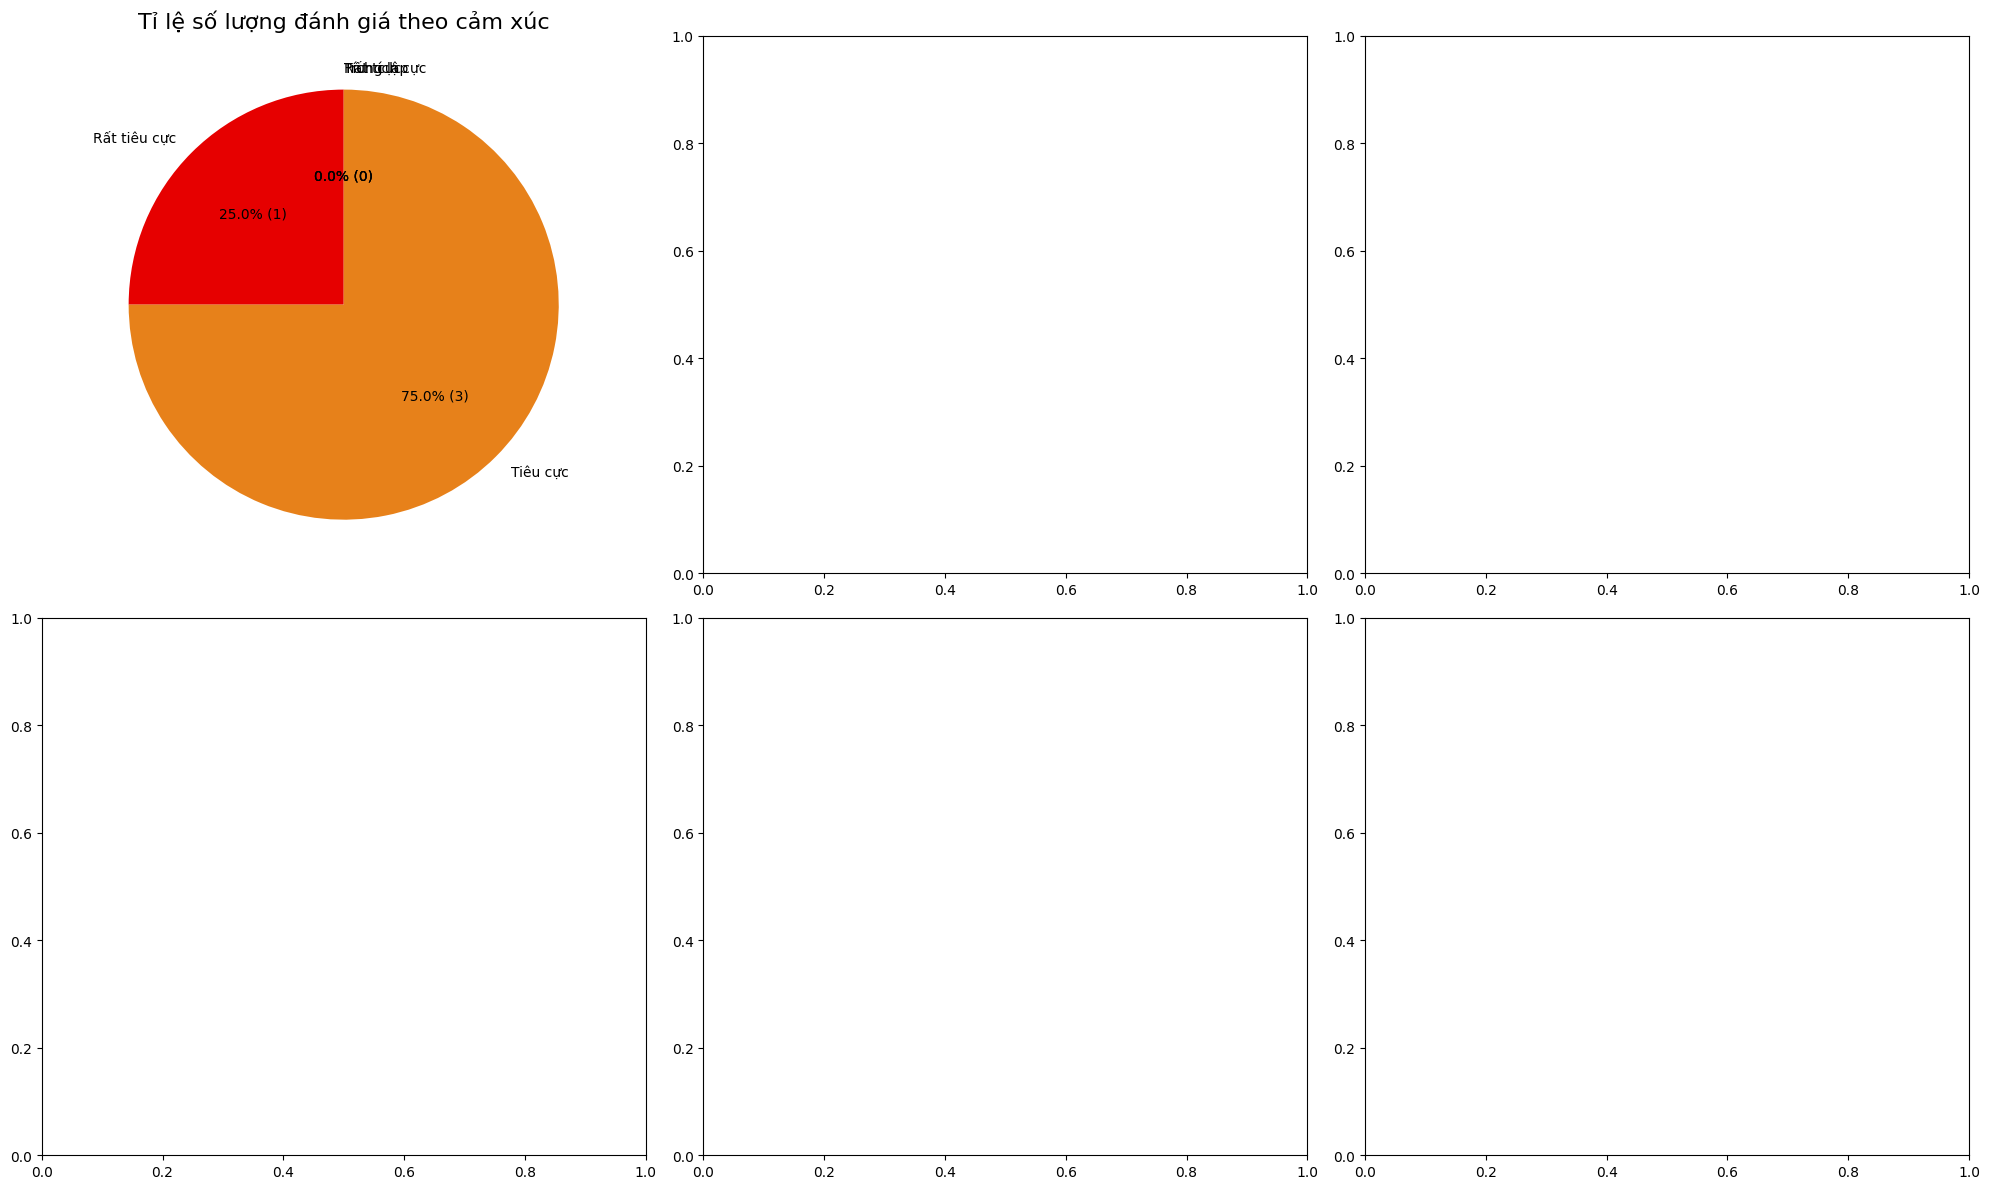

In [70]:
data_path = r'F:/Phuc/DUE/Năm 4/Khai phá Dữ liệu Web/Báo cáo Cuối kỳ/Data_web'
df_tfidf = pd.DataFrame(list_text)
# Lấy từ phổ biến nhất theo từng loại sao
top_words_by_rating = extract_top_tfidf_words_per_rating(df_tfidf, num_words=15)

# Vẽ biểu đồ
plot_pie_and_tfidf_bars(top_words_by_rating, df_tfidf, data_path)

In [71]:
from dotenv import load_dotenv
import cloudinary
from cloudinary import CloudinaryImage
import cloudinary.uploader
import cloudinary.api

In [78]:
def upload_image(data_path):
    load_dotenv(dotenv_path = f'{data_path}/.env')

    # Upload the image.
    # Set the asset's public ID and allow overwriting the asset with new versions
    cloudinary.config(
    cloud_name=os.getenv("CLOUDINARY_CLOUD_NAME"),
    api_key=os.getenv("CLOUDINARY_API_KEY"),
    api_secret=os.getenv("CLOUDINARY_API_SECRET"),
    secure=True
    )

    response = cloudinary.uploader.upload(f"{data_path}/dashboard.png", 
                                public_id = 'Khai_pha_Web', 
                                unique_filename = False, 
                                overwrite = True,
                                folder="Khai_pha_Web")

    image_url = response['secure_url']
    
    return image_url

In [79]:
upload_image(data_path)

'https://res.cloudinary.com/day4wv1aw/image/upload/v1735107945/Khai_pha_Web/Khai_pha_Web.png'